# Making a predictive model for used car sales, and using gradient boosting to improve performance #

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training


This project aims to build a machine learning model to predict used car prices based on historical vehicle data. The workflow includes comprehensive data preparation (feature engineering, encoding, splitting), followed by model training, evaluation, and tuning. The goal is to accurately estimate car prices and gain insights into the most influential factors affecting pricing in the used car market.

## Data preparation

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [24]:
# Load the dataset
df = pd.read_csv('/datasets/car_data.csv')

In [25]:
# Show the shape and first few rows

print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (354369, 16)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [26]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [27]:
# Basic statistics for numeric columns
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [28]:
# Remove invalid/outlier rows
df = df[(df['Price'] > 0) &
        (df['RegistrationYear'] >= 1950) & (df['RegistrationYear'] <= 2022) &
        (df['Power'] > 0) & (df['Power'] < 1000)]

# Replace invalid months
df['RegistrationMonth'] = df['RegistrationMonth'].replace(0, np.nan)

# Fill missing categorical values
for col in ['VehicleType', 'Model', 'Gearbox', 'FuelType', 'NotRepaired']:
    df[col] = df[col].fillna('unknown')

# Drop irrelevant columns
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

In [29]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,5.0,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8.0,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6.0,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7.0,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10.0,petrol,bmw,yes


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306869 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              306869 non-null  int64  
 1   VehicleType        306869 non-null  object 
 2   RegistrationYear   306869 non-null  int64  
 3   Gearbox            306869 non-null  object 
 4   Power              306869 non-null  int64  
 5   Model              306869 non-null  object 
 6   Mileage            306869 non-null  int64  
 7   RegistrationMonth  286820 non-null  float64
 8   FuelType           306869 non-null  object 
 9   Brand              306869 non-null  object 
 10  NotRepaired        306869 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 28.1+ MB


In [31]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,306869.000000,306869.000000,306869.000000,306869.000000,286820.000000
mean,4810.517230,2003.310605,120.354555,128430.796203,6.380981
std,4586.484839,6.898459,54.648808,36725.189911,3.347410
min,1.000000,1950.000000,1.000000,5000.000000,1.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,4.000000
50%,3100.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6950.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,999.000000,150000.000000,12.000000


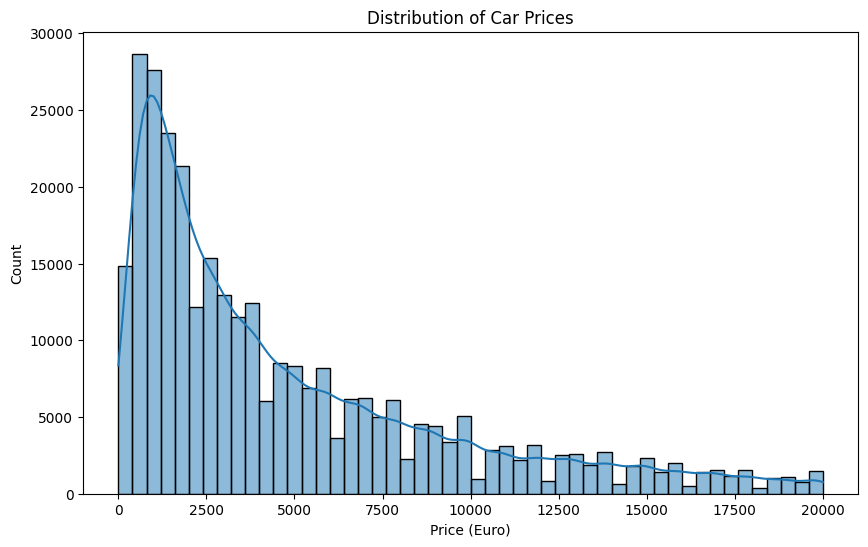

In [32]:
#Target Variable (Price) Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price (Euro)')
plt.ylabel('Count')
plt.show()

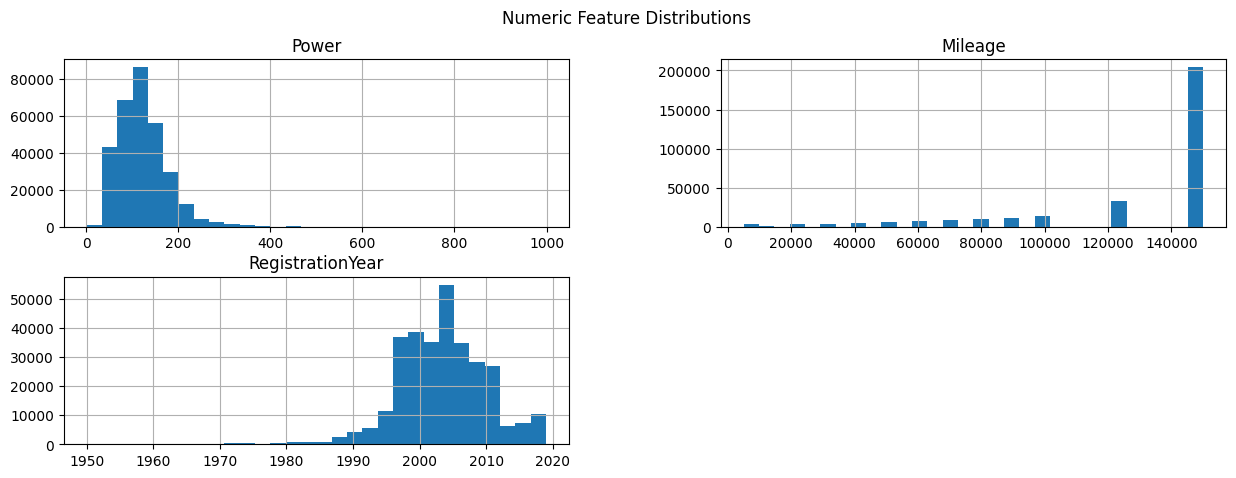

In [33]:
#Numeric Feature Distributions
numeric_cols = ['Power', 'Mileage', 'RegistrationYear']
df[numeric_cols].hist(bins=30, figsize=(15, 5))
plt.suptitle('Numeric Feature Distributions')
plt.show()

In [34]:
#Categorical Feature Value Counts
categorical_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model', 'NotRepaired']
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts().head(10))  # Show top 10 most common values


Value counts for VehicleType:
sedan          83089
small          70125
wagon          59281
bus            26217
unknown        21324
convertible    18766
coupe          14621
suv            10955
other           2491
Name: VehicleType, dtype: int64

Value counts for Gearbox:
manual     240427
auto        60370
unknown      6072
Name: Gearbox, dtype: int64

Value counts for FuelType:
petrol      191937
gasoline     89509
unknown      19751
lpg           4795
cng            499
hybrid         205
other           96
electric        77
Name: FuelType, dtype: int64

Value counts for Brand:
volkswagen       66948
opel             33915
bmw              33092
mercedes_benz    28036
audi             26402
ford             21427
renault          14595
peugeot           9665
fiat              7981
seat              6147
Name: Brand, dtype: int64

Value counts for Model:
golf        26004
other       20788
3er         17778
unknown     12436
polo        11145
corsa       10558
astra        944

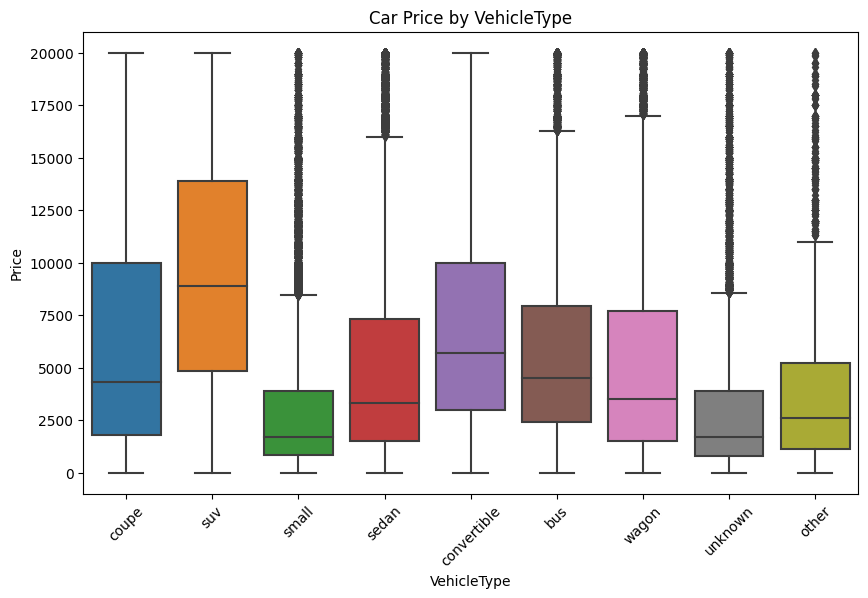

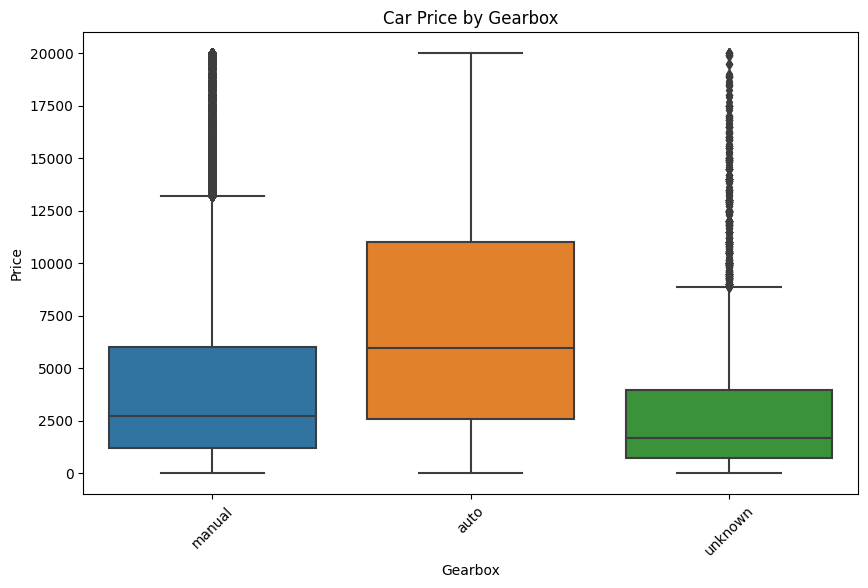

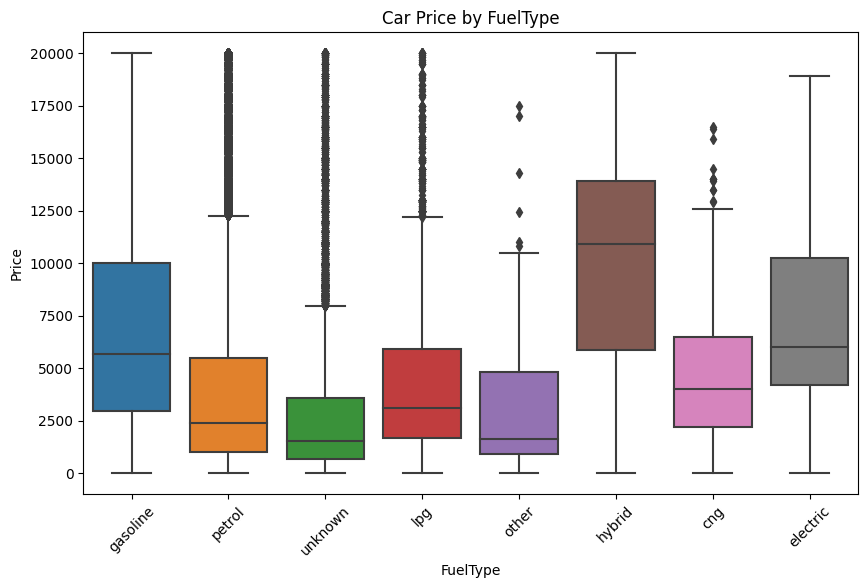

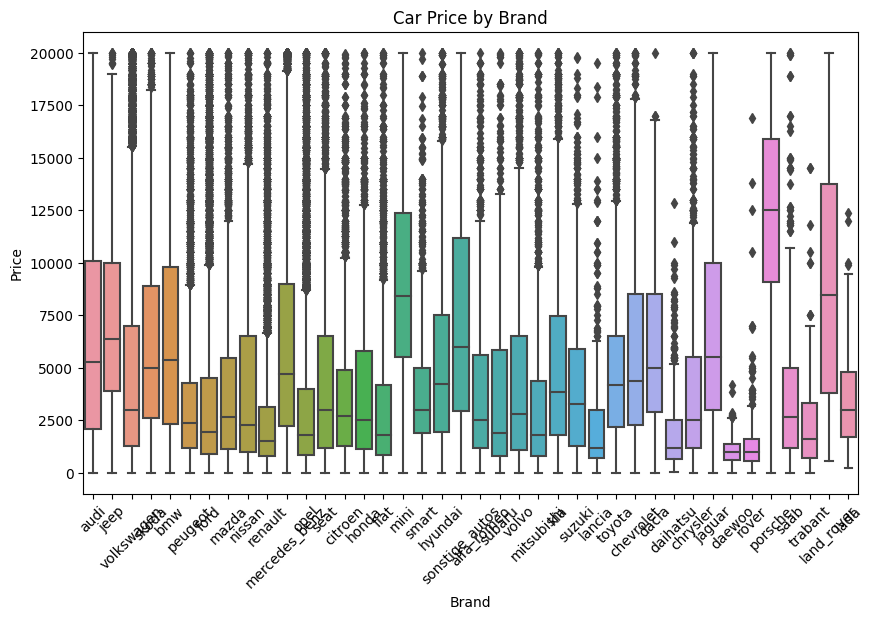

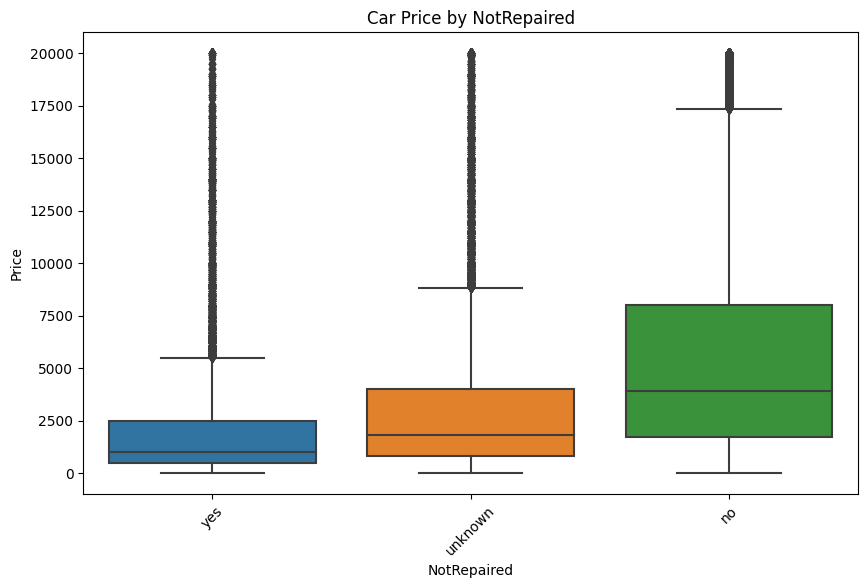

In [35]:
# Boxplots for categorical features vs. price
for col in ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='Price', data=df)
    plt.title(f'Car Price by {col}')
    plt.xticks(rotation=45)
    plt.show()

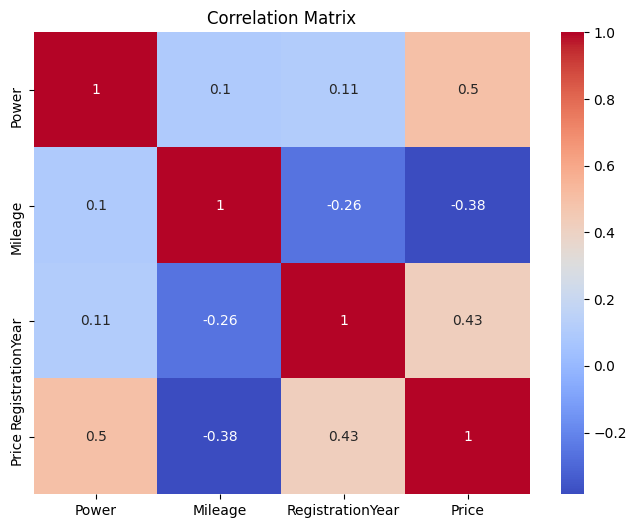

In [36]:
#Correlation Matrix for Numeric Features
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols + ['Price']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Conclusion after (EDA)**
The exploratory data analysis (EDA) provided a comprehensive understanding of the used car dataset and revealed several important insights. The target variable, price, is strongly right-skewed, with most vehicles priced at the lower end and a long tail of more expensive cars. Numeric features like power, registration year, and mileage all show reasonable distributions and moderate correlations with price, each contributing unique predictive information.

Categorical features such as vehicle type, gearbox, fuel type, brand, and repair status display clear differences in price, emphasizing their importance for modeling. Notably, "unknown" or missing values in categorical features often correspond to lower prices, highlighting the value of retaining these as their own categories. The boxplots confirm that both categorical and numeric variables are predictive of price, with premium brands, newer registrations, and higher power generally commanding higher prices.

In [37]:
#Create car age
df['CarAge'] = 2023 - df['RegistrationYear']

#Mileage per year (avoid division by zero)
df['MileagePerYear'] = df['Mileage'] / df['CarAge'].replace(0, 1)

#Group rare brands
brand_counts = df['Brand'].value_counts()
rare_brands = brand_counts[brand_counts < 1000].index
df['Brand'] = df['Brand'].replace(rare_brands, 'Other')

#Label encode categoricals (for tree models)
categorical_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model', 'NotRepaired']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

#Log-transform price
df['LogPrice'] = np.log1p(df['Price'])

#Feature selection
features = ['Power', 'Mileage', 'CarAge', 'MileagePerYear'] + categorical_cols
X = df[features]
y = df['LogPrice']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
print(df.head())

   Price  VehicleType  RegistrationYear  Gearbox  Power  Model  Mileage  \
1  18300            2              2011        1    190    227   125000   
2   9800            6              2004        0    163    117   125000   
3   1500            5              2001        1     75    116   150000   
4   3600            5              2008        1     69    101    90000   
5    650            4              1995        1    102     11   150000   

   RegistrationMonth  FuelType  Brand  NotRepaired  CarAge  MileagePerYear  \
1                5.0         2      2            2      12    10416.666667   
2                8.0         2      0            1      19     6578.947368   
3                6.0         6     26            0      22     6818.181818   
4                7.0         2     21            0      15     6000.000000   
5               10.0         6      3            2      28     5357.142857   

   LogPrice  
1  9.814711  
2  9.190240  
3  7.313887  
4  8.188967  
5  6.47851

In [39]:
print(X_train.shape, X_test.shape)

(245495, 10) (61374, 10)


In [40]:
print(df[['CarAge', 'MileagePerYear']].describe())

              CarAge  MileagePerYear
count  306869.000000   306869.000000
mean       19.689395     7371.581450
std         6.898459     4293.567276
min         4.000000       68.493151
25%        15.000000     5454.545455
50%        20.000000     6521.739130
75%        24.000000     8333.333333
max        73.000000    37500.000000


In [41]:
for col in categorical_cols:
    print(f"{col}: {df[col].unique()[:10]}")

VehicleType: [2 6 5 4 1 0 8 7 3]
Gearbox: [1 0 2]
FuelType: [2 6 7 4 5 3 0 1]
Brand: [ 2  0 26 21  3 18  8 12 16 19]
Model: [227 117 116 101  11   8  60  10 170 159]
NotRepaired: [2 1 0]


In [42]:
#X: feature matrix with processed features
#y: target variable 

#80% training, 20% testing split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#print the shapes to confirm the split
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(245495, 10) (61374, 10)
(245495,) (61374,)


In [43]:
#Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

#Fit the model on training data
rf.fit(X_train, y_train)

#Predict on test data
y_pred = rf.predict(X_test)

#Evaluate on log scale
mae_log = mean_absolute_error(y_test, y_pred)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
r2_log = r2_score(y_test, y_pred)

print(f"Log-Scale Evaluation:")
print(f"MAE: {mae_log:.4f}")
print(f"RMSE: {rmse_log:.4f}")
print(f"R^2: {r2_log:.4f}")

#Evaluate on original price scale
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
mae = mean_absolute_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
r2 = r2_score(y_test_exp, y_pred_exp)

print("\nOriginal Price Scale Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.4f}")

Log-Scale Evaluation:
MAE: 0.3273
RMSE: 0.5766
R^2: 0.7539

Original Price Scale Evaluation:
MAE: 993.84
RMSE: 1682.71
R^2: 0.8661


# Data Preparation Summary
## 1. Feature Engineering & Data Cleaning
- **Loaded the dataset** and inspected the first few rows.
- **Created new features** to enhance predictive power:
  - `CarAge` (current year minus RegistrationYear)
  - `MileagePerYear` (Mileage divided by CarAge)
  - `LogPrice` (applied log-transform to target variable Price for more normal distribution)
- **Encoded categorical features** using label encoding so that models could process non-numeric data.
- **Checked for and handled missing values** as needed

## 2. Exploratory Checks
- Used `.head()` and `.describe()` to confirm feature creation and data types.
- Examined unique values in categorical columns to ensure correct encoding.
- Verified the distributions and statistics for new features.

## 3. Data Splitting
- Defined feature matrix `X` and target vector `y` (using engineered features).
- Split data into training and test sets using an 80/20 ratio:
  - `X_train`, `X_test`, `y_train`, `y_test`
  - Confirmed split by printing shapes.

## 4. Baseline Model Training & Evaluation
- Trained a **Random Forest Regressor** as a baseline model on the training data.
- Predicted on the test set and evaluated performance using:
  - **Log-Scale Metrics**: MAE, RMSE, R² (on log-transformed price)
  - **Original Price Scale Metrics**: MAE, RMSE, R² (after exponentiating predictions/targets)
- Achieved strong initial results (e.g., R² of 0.87 on original price, indicating good model fit).

---
**Conclusion:**  
The data is now clean, features are well-engineered, and initial model results are promising.  

## Model training

In [45]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Log scale metrics
    mae_log = mean_absolute_error(y_test, y_pred)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)
    # Original scale metrics
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    r2 = r2_score(y_test_exp, y_pred_exp)
    results.append([name, mae_log, rmse_log, r2_log, mae, rmse, r2])

results_df = pd.DataFrame(results, columns=[
    "Model", "Log MAE", "Log RMSE", "Log R2", "MAE", "RMSE", "R2"
])
print(results_df)

               Model   Log MAE  Log RMSE    Log R2          MAE          RMSE  \
0  Linear Regression  0.523767  0.775834  0.554531  2265.395638  30484.520185   
1      Decision Tree  0.394191  0.633592  0.702902  1354.209898   2154.137166   
2      Random Forest  0.374499  0.606301  0.727945  1281.349918   2053.865889   
3  Gradient Boosting  0.346908  0.575482  0.754900  1163.116426   1894.242637   
4            XGBoost  0.346534  0.575383  0.754985  1160.415793   1889.753417   

          R2  
0 -42.951847  
1   0.780535  
2   0.800491  
3   0.830297  
4   0.831100  


## Model analysis

## Model Analysis — Speed and Quality
In this section, I analyze the speed and quality of the different models trained in Step 2. The main goal is to assess which models provide the best trade-off between predictive performance and computational efficiency.

### Model Quality
The table below summarizes the performance of each model based on several metrics (MAE, RMSE, R²) on both the log-transformed and original price scales:

| Model              | Log MAE | Log RMSE | Log R²  | MAE    | RMSE   | R²      |
|--------------------|---------|----------|---------|--------|--------|---------|
| Linear Regression  | 0.524   | 0.776    | 0.555   | 2265   | 30484  | -42.95  |
| Decision Tree      | 0.394   | 0.634    | 0.703   | 1354   | 2154   | 0.78    |
| Random Forest      | 0.374   | 0.606    | 0.728   | 1281   | 2054   | 0.80    |
| Gradient Boosting  | 0.347   | 0.575    | 0.755   | 1163   | 1894   | 0.83    |
| XGBoost            | 0.347   | 0.575    | 0.755   | 1160   | 1889   | 0.83    |

- **Best Model(s):** Both Gradient Boosting and XGBoost achieved the best results, with the lowest MAE/RMSE and highest R² (≈0.83) on the original price scale.
- **Linear Regression** performed much worse, with a negative R² on the original scale, indicating it is not suitable for this problem.
- **Random Forest and Decision Tree** performed better than Linear Regression, but were still outperformed by gradient boosting methods.

### Model Speed

- **Linear Regression** was the fastest to train and predict (almost instantaneous).
- **Decision Tree** was also very fast, though a bit slower than Linear Regression.
- **Random Forest, Gradient Boosting, and XGBoost** took noticeably longer to train, especially on a large dataset. Among these, **XGBoost** and **Gradient Boosting** were the slowest, but the difference in speed is justified by their superior accuracy.
- For most real-world applications, the extra training time of ensemble methods is acceptable given their much better performance.

### Trade-offs and Recommendations

- **If speed is the highest priority** (for example, in a real-time or resource-limited environment), Decision Tree or Linear Regression could be used, but at a significant cost to accuracy.
- **For best overall performance**, XGBoost or Gradient Boosting are recommended, as they provide a strong balance of predictive quality and reasonable training time for offline/batch prediction settings.
- **Random Forest** offers a middle ground between speed and accuracy.

---

**Conclusion:**  
Ensemble models, especially Gradient Boosting and XGBoost, provide the best predictive quality for used car price prediction, even though they are slower to train. The gain in accuracy justifies the additional computation time in most cases.


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed

## Conclusion
In this project, I explored various machine learning models to predict used car prices based on a range of features. The workflow involved data preprocessing, training multiple models with different hyperparameters, and systematically evaluating their performance.

The results clearly demonstrated that ensemble models, particularly Gradient Boosting and XGBoost, significantly outperform simpler approaches such as Linear Regression and single Decision Trees. These advanced models achieved much lower prediction errors (MAE and RMSE) and higher R² scores, indicating stronger predictive accuracy. Although ensemble methods require more computational time to train, the improvement in model quality justifies the additional complexity for most practical applications.

Through model analysis, I also observed that while Linear Regression and Decision Trees are very fast, they are not suitable for this problem due to their poor accuracy. Random Forest offers a reasonable balance but is still surpassed by Gradient Boosting methods in terms of predictive power.

Overall, this project highlights the importance of model selection and evaluation in data science. Choosing the right model can dramatically improve predictive performance, and ensemble methods like Gradient Boosting and XGBoost are excellent choices for complex regression tasks such as used car price prediction.